# Clean!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA 
from scipy.signal import *

#one can add this library on this link https://pypi.org/project/behavelet/
#or directly running "pip install behavelet" on Conda or Python
from behavelet import wavelet_transform

# K-MEAN
from sklearn.cluster import KMeans

# GMM clustering
from sklearn import mixture

#correlation
import seaborn as sns

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/behavelet/morlet.py:26: UserWarning: CuPy was not found, so GPU functionality is unavailable. See https://github.com/cupy/cupy#installation for installation instructions
  warnings.warn('CuPy was not found, so GPU functionality is unavailable. '


# 1.  Loading the behavioural/neural data

In [2]:
beh_data_dir = "data/COBAR_behaviour_incl_manual_corrected.pkl"
beh_df = pd.read_pickle(beh_data_dir)

In [3]:
neural_data_dir = beh_data_dir = "data/COBAR_neural.pkl"
neural_df = pd.read_pickle(neural_data_dir)

# 2. Data Preprocessing

### A. Noise reduction

In [4]:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

#filter angles in beh data
fs=100.0
order=2
cutoff=20
filtered_beh_df = beh_df.copy(deep=True)
angl=beh_df.filter(regex="angle")
filtered_angl = butter_lowpass_filter(angl, cutoff, fs, order)
filtered_beh_df.iloc[:,2:44]=filtered_angl
#filter neurons reading in neural data
filtered_neural_df = neural_df.copy(deep=True) #necessary to deep copy dataaframe
fs=16.0
order=2
cutoff=2.5
neurons=neural_df.filter(regex="neuron")
filtered_neurons = butter_lowpass_filter(neurons, cutoff, fs, order)
filtered_neural_df.iloc[:,1:124]=filtered_neurons

### B. Performing ΔF/F on neural data

In [5]:
#Δ𝐹/𝐹 = (F − Fb)/𝐹b , where Fb is the baseline fluorescence.
# return baselined neural data
def neural_dF_F(data):
    rlt_Df_f=data.copy()
    nb_neurons = np.size(data,1)
    
    for j in np.arange(nb_neurons-1): 
        baseline = data['neuron_' + str(j)].rolling(window=3).mean()
        rlt_Df_f['neuron_' + str(j)] = (data['neuron_' + str(j)]-abs(baseline.min()))/abs(baseline.min())
    return rlt_Df_f

#final step of pre-processing : performing Delta_F/F on denoised signals
filtered_neural_df = neural_dF_F(filtered_neural_df)

In [6]:
# Global Parameters
nb_trials = 12
frames_in_trial = 4040

#time vector
t = filtered_neural_df["t"]
time = t[t.index.get_level_values("Trial")==0]
time_offset = time.iloc[-1]
for i in range(nb_trials-1):
    time_trial_i = t[t.index.get_level_values("Trial")==(i+1)]
    time = pd.concat([time, time_trial_i+time_offset], axis=0)
    time_offset = time_offset + time_trial_i.iloc[-1]

### C. Downsampling manual labels

In [7]:
# these two functions are just wrappers around the numpy functions to apply them across dimension 0 only
def reduce_mean(values):
    return np.mean(values, axis=0)
def reduce_std(values):
    return np.std(values, axis=0)
def reduce_behaviour(values):
    """
    this is just a sketch for how to reduce behavioural classes. 
    It picks whatever behaviour occurs the most.
    Try to make this more stable, for example by handling the case when two behaviours are equally likely.
    You might also want to include a certainty threshold, 
    e.g. 3/4 of the behaviour frames have to be labelled the same way, otherwise it is None and the data is excluded
    """
    unique_values, N_per_unique = np.unique(values, return_counts=True)
    i_max = np.argmax(N_per_unique)
    return unique_values[i_max]

def reduce_during_2p_frame(twop_index, values, function=reduce_mean):
    """
    Reduces all values occuring during the acquisition of a
    two-photon imaging frame to a single value using the `function` given by the user.
    Parameters
    ----------
    twop_index : numpy array
        1d array holding frame indices of one trial.
    values : numpy array
        Values upsampled to the frequency of ThorSync,
        i.e. 1D numpy array of the same length as
        `frame_counter` or 2D numpy array of the same length.
    function : function
        Function used to reduce the value,
        e.g. np.mean for 1D variables
    Returns
    -------
    reduced : numpy array
        Numpy array with value for each two-photon imaging frame.
    """
    
    if len(twop_index) != len(values):
        raise ValueError("twop_index and values need to have the same length.")
    if len(values.shape) == 1:
        values = np.expand_dims(values, axis=1)
        squeeze = True
    else:
        squeeze = False
    N_samples, N_variables = values.shape
    
    index_unique = np.unique(twop_index)
    index_unique = np.delete(index_unique, index_unique==-9223372036854775808)
    
    dtype = values.dtype
    if np.issubdtype(dtype, np.number):
        dtype = np.float
    else:
        dtype = np.object
    reduced = np.empty((len(index_unique), N_variables), dtype=dtype)

    for i, index in enumerate(index_unique):
        reduced[i] = function(values[twop_index==index, :])

    return np.squeeze(reduced) if squeeze else reduced

In [8]:
# apply downsampling to manual labels
twop_index = filtered_beh_df.loc[(210301, "J1xCI9", 1, 0), "twop_index"].to_numpy()
values = filtered_beh_df.loc[(210301, "J1xCI9", 1, 0), "Manual"].to_numpy()
reduced_labels = reduce_during_2p_frame(twop_index, values, function=reduce_behaviour)

# 3. Investigate clustering of neurons' activity: find neurons that correlate with each other

This section aims at finding neurons that activate at similar times. This is done by doing a Principal Component Analysis (PCA) followed by clastering. The clastering is then evaluated using inter-neuron correlation.

### A. PCA 

In [9]:
# Functions required for PCA 

# normalise the data
def normalise(data):
    Feature_scaler = sklearn.preprocessing.StandardScaler().fit(data)
    return sklearn.preprocessing.scale(data)

# apply PCA:  
# input samples: neurons
# input features: time samples
def PCA_temporal(data_norm, time, plot=False):

    pca = PCA(n_components=27)
    data_new = pca.fit_transform(data_norm.T)
    print('Variance explained by first 27 pricipal components:')
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))
    
    if plot:
        #plot loadings
        fig, ax = plt.subplots()
        loadings = pd.DataFrame(pca.components_[0:2].T, columns=['PC1', 'PC2'])
        plt.plot(time, loadings['PC1'], label = 'PC1', alpha=0.5)
        plt.plot(time, loadings['PC2'], label = 'PC2', alpha=0.5)
        plt.title('PCA Loadings of Neural Activity')
        plt.xlabel('Time point [s]')
        plt.ylabel('PCA weight')
        plt.legend()
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_loadings.png')
        
        fig, ax = plt.subplots()
        #scatter plot of first two components
        plt.scatter(data_new[:,0], data_new[:,1], alpha = 0.5) 
        plt.title('PCA Projected Neurons')
        plt.xlabel('PCA component 1 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
        plt.ylabel('PCA component 2 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_scatter.png')
        
    return data_new, pca

Variance explained by first 27 pricipal components:
[0.27332419 0.26424122 0.06765547 0.03619374 0.0326937  0.0254746
 0.02292318 0.01734588 0.01707517 0.01548904 0.01295125 0.01225216
 0.01175105 0.01067087 0.00938811 0.00884934 0.00829765 0.0077056
 0.00727827 0.00614919 0.00559445 0.00521619 0.00487056 0.00451013
 0.00439967 0.00417747 0.00377953]
0.9002576906519751


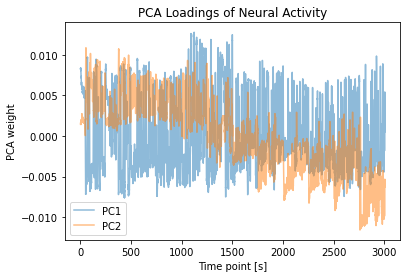

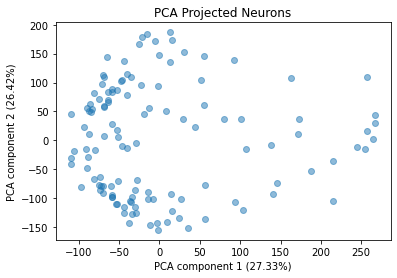

In [10]:
# PCA implementation (all trials are used as data)
X = filtered_neural_df.filter(regex="neuron")

X_norm = normalise(X)
X_new, pca = PCA_temporal(X_norm, time, plot=True)


### B. clustering
After the dimension reduction done with the PCA, the neurons can be clastered. These clusters represent neurons that have similar signals.

In [11]:
# cluster data using kmeans
# returns the classes and class names
def kmeans_cluster(data, nb_clusters, plot=False):
    
    #fit kmeans
    kmeans = KMeans(n_clusters=nb_clusters, init='random', n_init=1, verbose=0)
    kmeans.fit(data)
    labels = kmeans.labels_
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of KMEANS clusters
        fig, ax = plt.subplots()
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('KMEANS clustering')
        plt.legend(class_names)
        plt.show()
        fig.savefig('report_images/cluster_kmeans.png')
    
    return labels, class_names

# cluster data using GMM
# returns the classes and class names
def GMM_cluster(data, nb_components, plot=False):
    
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=nb_components, covariance_type='full').fit(data)
    
    labels = gmm.predict(data)
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of GMM clusters
        fig, ax = plt.subplots()
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('GMM clustering')
        plt.legend(class_names)
        plt.show()
        fig.savefig('report_images/cluster_GMM.png')
        
    return labels, class_names

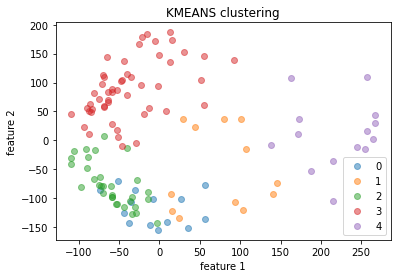

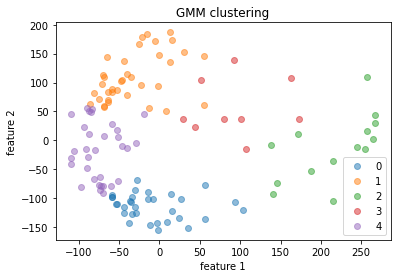

In [12]:
kmeans_labels, kmeans_names = kmeans_cluster(X_new, nb_clusters=5, plot=True)
GMM_labels, GMM_names = GMM_cluster(X_new, nb_components=5, plot=True)

### C. Neural activity of neurons from the same and different clusters

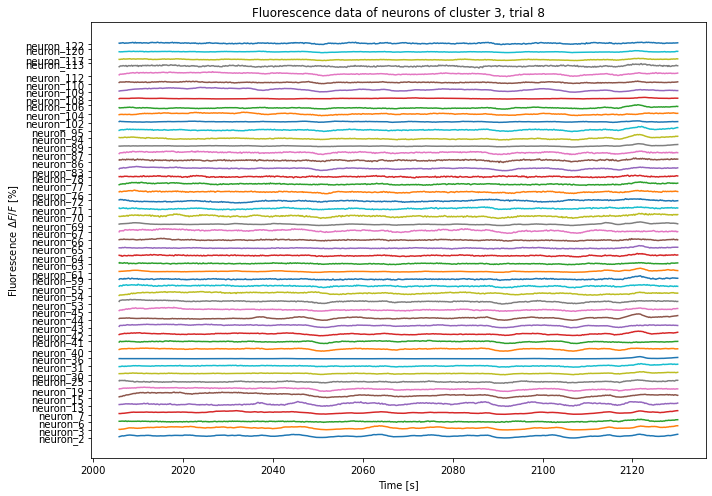

In [13]:
# compare neuronal activity of neurons of the same cluster: trial 8 (first half)
trial = 8
frame_i = int(frames_in_trial*(trial))
frame_f = int(frames_in_trial*(trial+0.5))

fig, ax = plt.subplots(figsize = (10,7))

ytick = []
neurons_cluster = np.where(kmeans_labels == kmeans_names[3])[0]
for i,neuro_id in enumerate(neurons_cluster): 
    neural_signals_neuron_i = X_norm[:,neuro_id]
    #plt.plot(time[time.index.get_level_values("Trial")==8], i*5 + neural_signals_neuron_i[4040*8:4040*9], label = 'neuron_' + str(neuro_id))
    plt.plot(time.iloc[frame_i:frame_f], i*5 + neural_signals_neuron_i[frame_i:frame_f], label = 'neuron_' + str(neuro_id))
    
    #frames_in_trial
    ytick.append(i*5 + neural_signals_neuron_i[0])
    
plt.ylabel('Fluorescence $\Delta F/F$ [%]')
plt.xlabel('Time [s]')
plt.title('Fluorescence data of neurons of cluster 3, trial 8')

plt.yticks(np.array(ytick))
neuron_names = ['neuron_' + str(i) for i in neurons_cluster]
ax.set_yticklabels(neuron_names)

plt.tight_layout()
plt.show()
fig.savefig('report_images/cluster3_signal.png')


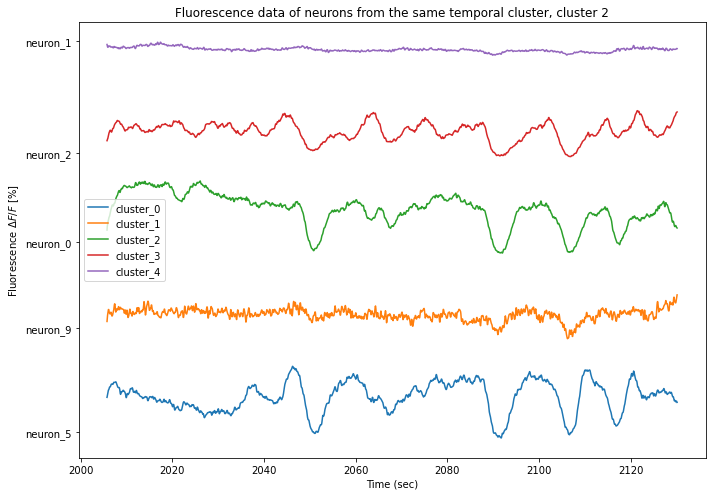

In [14]:
# compare neuronal activity of neurons of different clusters: trial 8
fig, ax = plt.subplots(figsize = (10,7))

ytick = []
neuron_names = []
for i in range(len(kmeans_names)):
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    neural_signals_neuron_i = X_norm[:,neurons_cluster[0]]
    #plt.plot(time[time.index.get_level_values("Trial")==8], i*5 + neural_signals_neuron_i[4040*8:4040*9], label = 'cluster_' + str(i))
    plt.plot(time.iloc[frame_i:frame_f], i*5 + neural_signals_neuron_i[frame_i:frame_f], label = 'cluster_' + str(i))
    
    ytick.append(i*5 + neural_signals_neuron_i[0])
    neuron_names.append('neuron_' + str(neurons_cluster[0]))
    
plt.ylabel('Fluorescence $\Delta F/F$ [%]')
plt.xlabel('Time (sec)')
plt.title('Fluorescence data of neurons from the same temporal cluster, cluster 2')

ax.set_yticks(np.array(ytick))
ax.set_yticklabels(neuron_names)
plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('report_images/clusters_diff_signal.png')

### D. Correlation
To evaluate the similarity between the signals of neurons from the same cluster, we can find their correlation coefficients.

In [15]:
# plot correlation coefficient of given data
def plot_correlation_coeff(data, title, filename):
    #Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (15,10))

    #Compute the correlation matrix
    correlation = data

    corr = correlation.corr()

    #Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    #Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.xlabel('neuron id')
    plt.ylabel('neuron id')
    plt.title(title)
    plt.show()
    fig.savefig('report_images/'+filename+'.png')

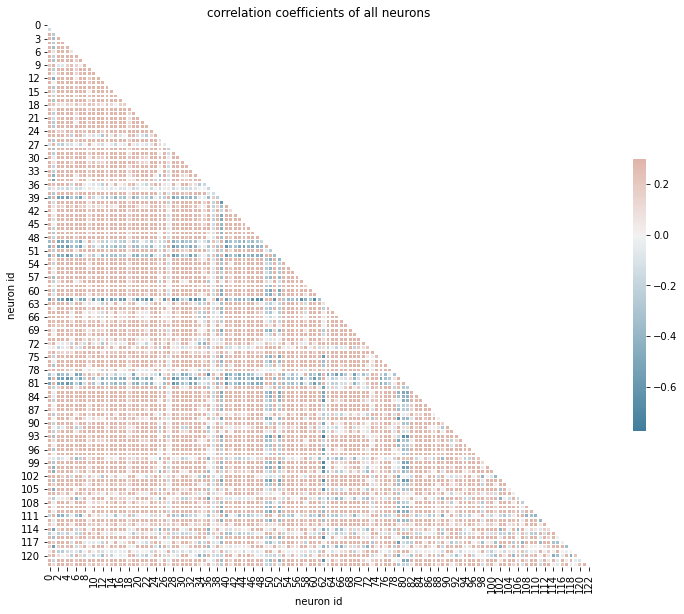

In [16]:
# correlation coefficient of all the neurons
plot_correlation_coeff(pd.DataFrame(data=X_norm), title='correlation coefficients of all neurons', filename='corr_all_neurons')

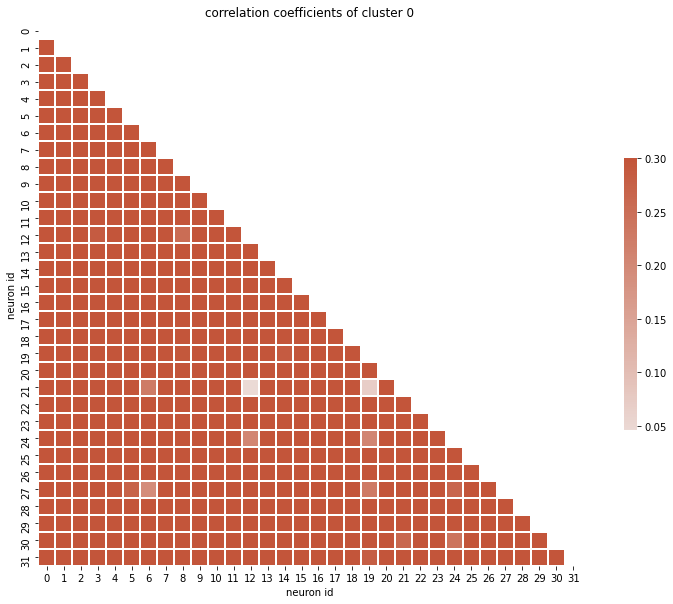

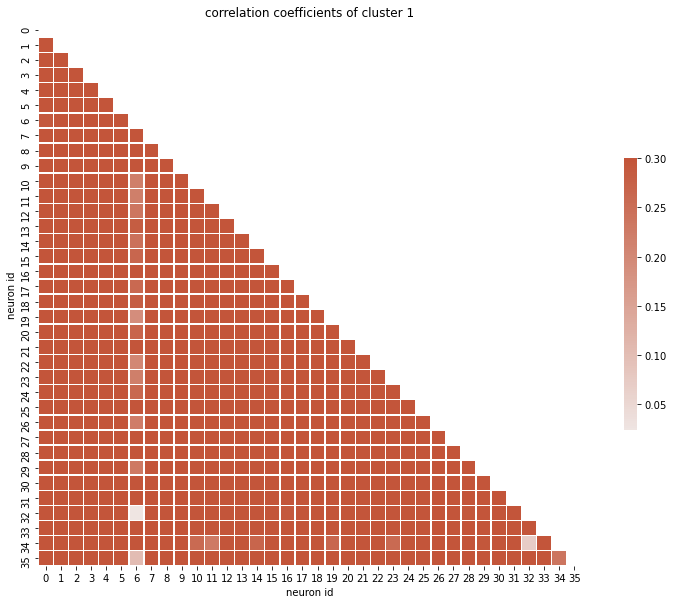

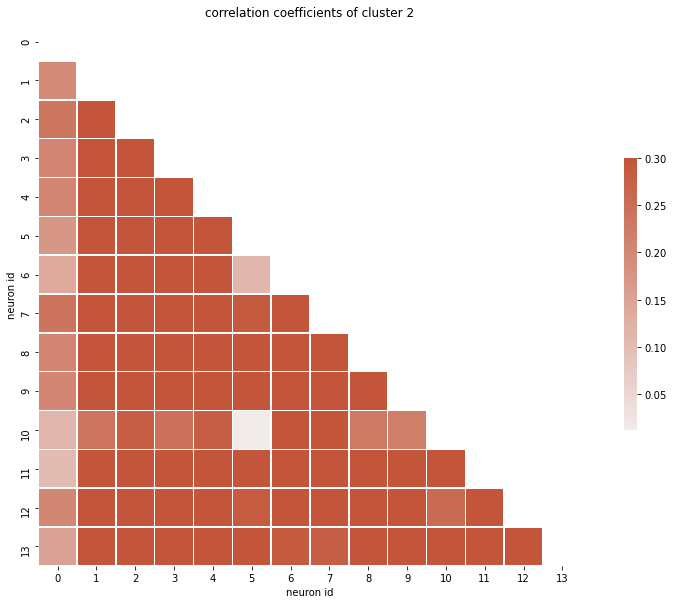

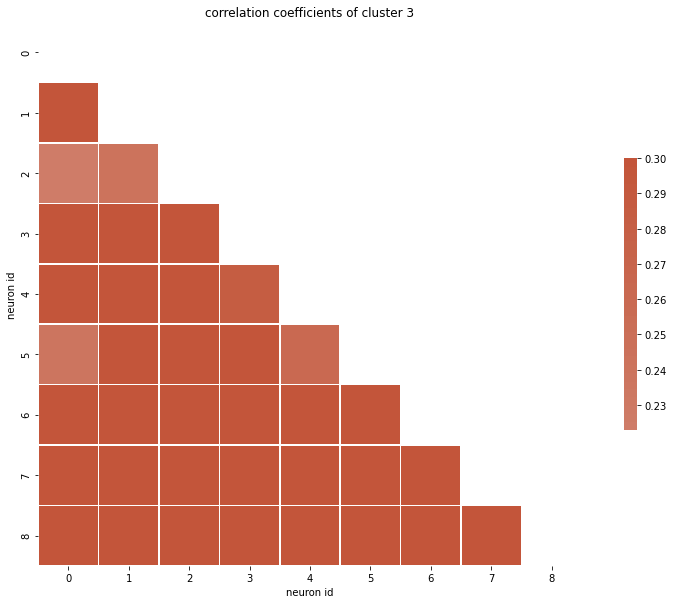

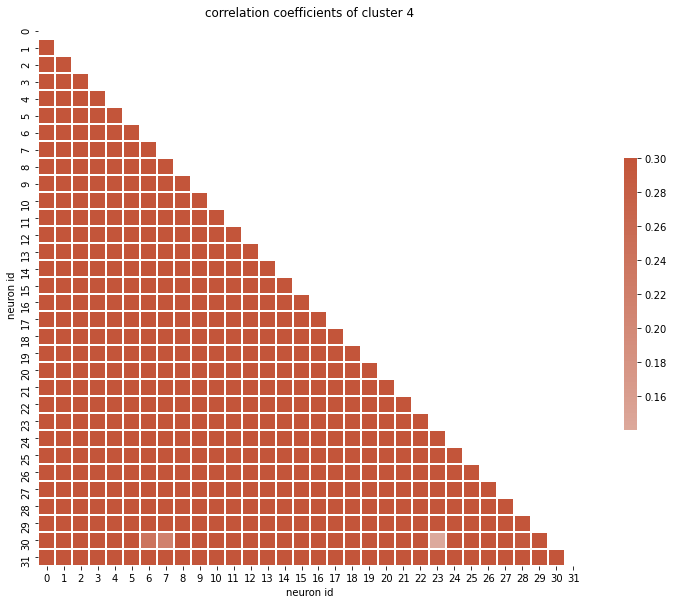

In [17]:
for i in range(len(GMM_names)):  
    neurons_cluster = np.where(GMM_labels == GMM_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i),\
                           filename='corr_gmm{}'.format(i))

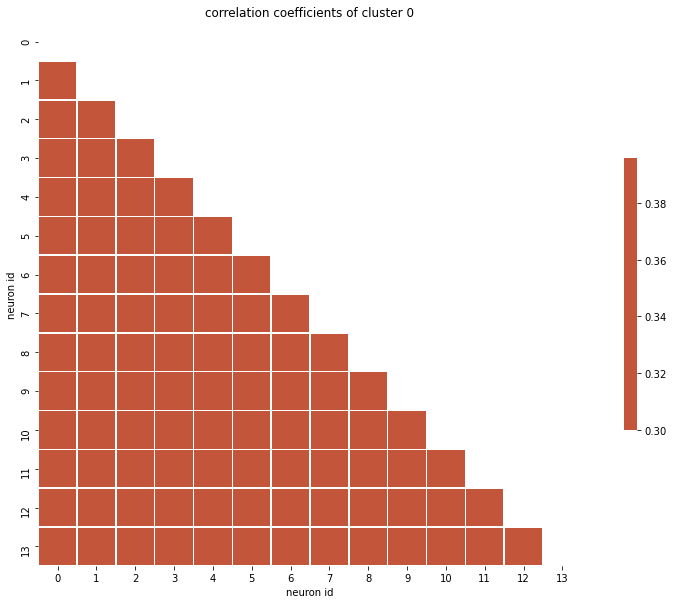

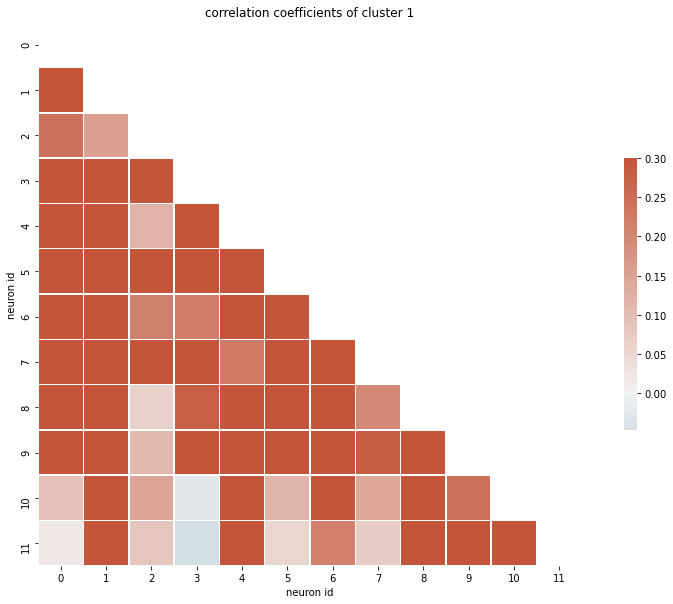

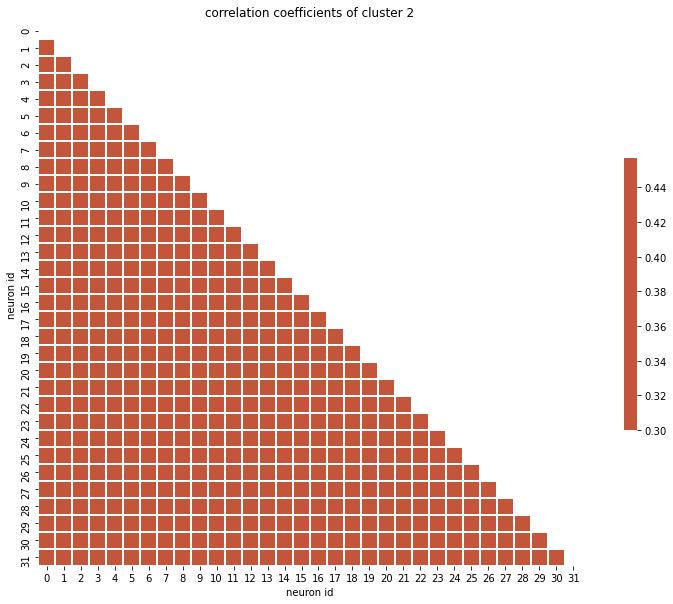

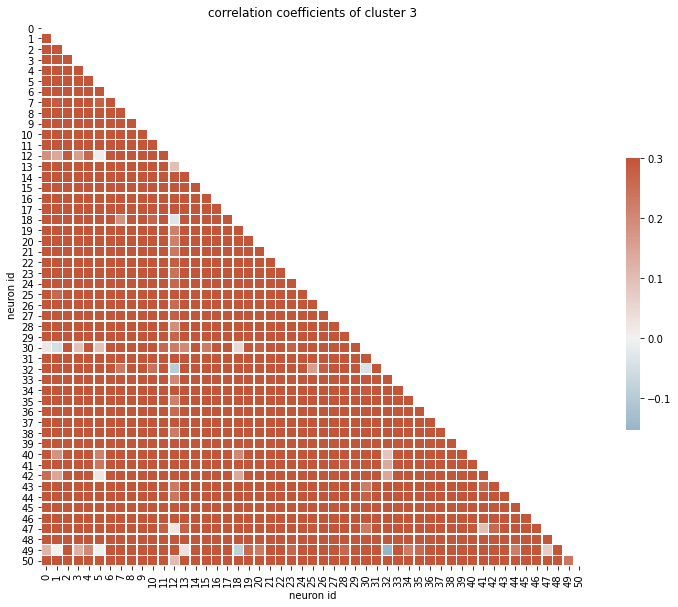

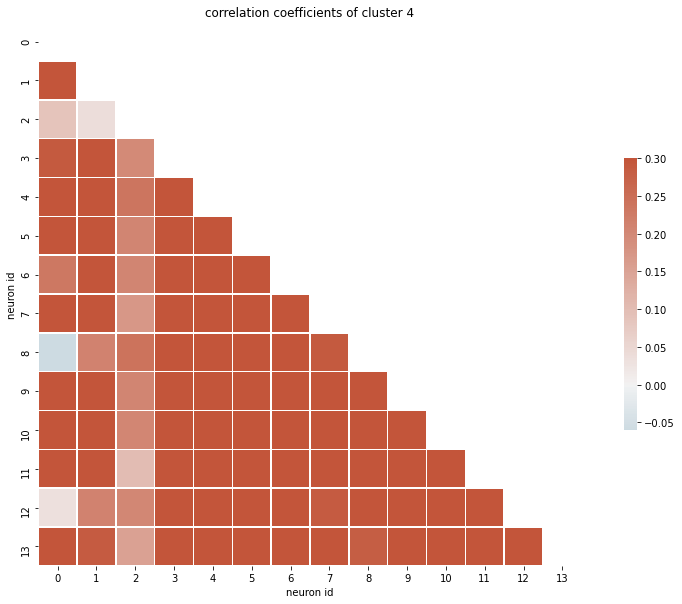

In [18]:

for i in range(len(kmeans_names)):  
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i),\
                          filename='corr_kmeans{}'.format(i))

# 4. Exploratory data analysis


### A. Correlation between neural activity and behaviour

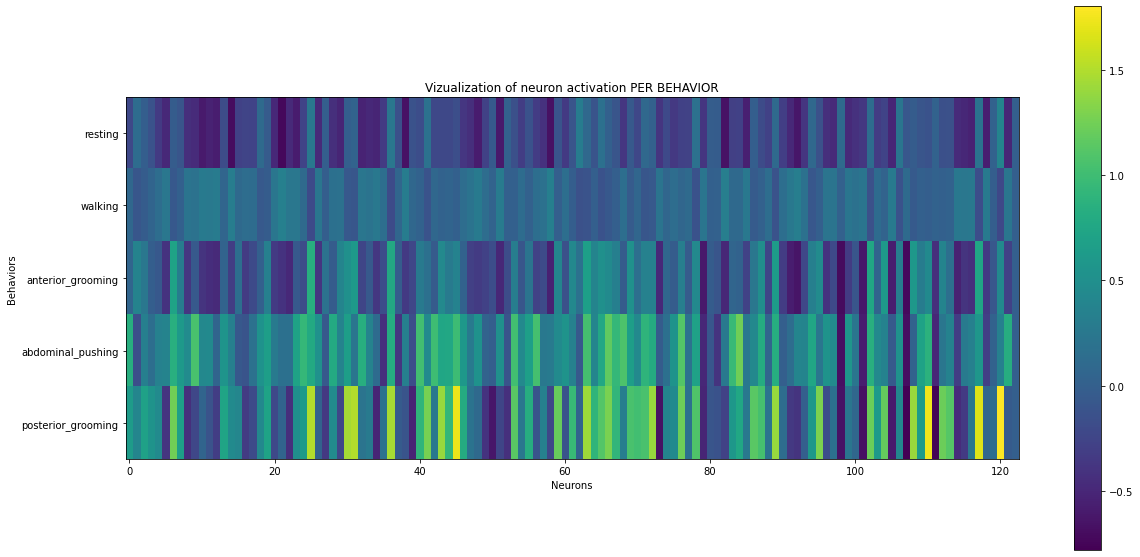

In [19]:
#step1 : standardization
std_Df_f = filtered_neural_df.copy()
for j in np.arange(123): 
    baseline = filtered_neural_df['neuron_' + str(j)].mean()
    std_Df_f['neuron_' + str(j)] = (filtered_neural_df['neuron_' + str(j)]-filtered_neural_df['neuron_' + str(j)].mean())/(filtered_neural_df['neuron_' + str(j)].std())

#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
std_Df_f['Manual'] = filtered_beh_df['Manual']
behaviors = ['resting', 'walking', 'anterior_grooming', 'abdominal_pushing', 'posterior_grooming']
ytick=[0,1,2,3,4]
val = np.zeros((5,123))

for i in range (len(behaviors)):
    b = behaviors[i]
    behavior_data = std_Df_f[std_Df_f['Manual']==b]
    behavior_data
    for j in range (122):
        val[i,j]=behavior_data['neuron_' + str(j)].mean()

fig, ax2 = plt.subplots(figsize = (20,10))
ax2.set_yticks(ytick)
ax2.set_yticklabels(behaviors)
ax2.set_title('Vizualization of neuron activation PER BEHAVIOR')
ax2.set_ylabel('Behaviors')
ax2.set_xlabel('Neurons')
plt.imshow(val, aspect=10)
plt.colorbar()
plt.show()
fig.savefig('report_images/neuron_act_per_behavior.png')

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

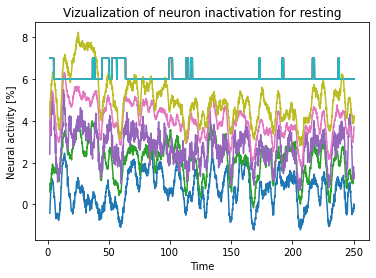

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

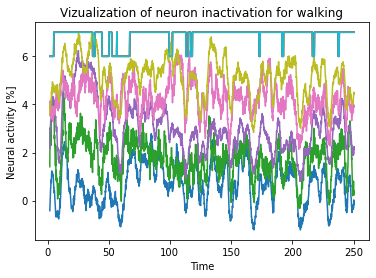

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

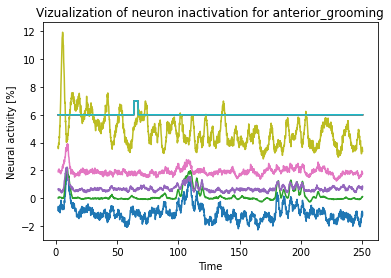

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

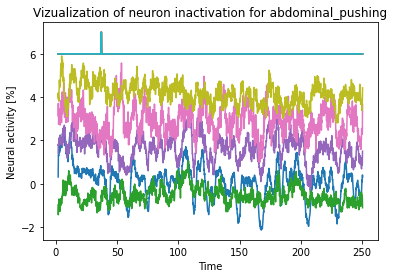

/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/mathiasnuris/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards

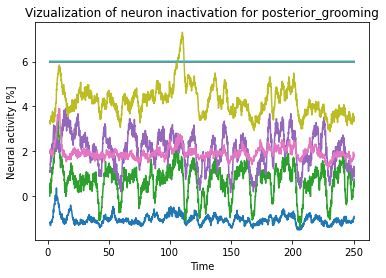

In [20]:
#getting more implicated neurons 
plots_act= val.copy()
nbr_required_neurons=5
neurons= np.zeros((5,nbr_required_neurons))

for i in range (len(behaviors)):
    for j in range (nbr_required_neurons):
        index_max=(np.int_((np.where(abs(plots_act[i])==abs(plots_act[i]).max()))))[0,0]
        neurons[i,j]=index_max
        plots_act[i,index_max]=0
        
neurons=np.int_(neurons)

#try for a specific trial, otherwise it's impossible to read it
try_trial = std_Df_f[std_Df_f.index.get_level_values("Trial")==11].copy(deep=True)
indexs_beh=[]

for i in range (len(neurons)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,4))
    
    for j in range (len(neurons[1])):
        plot_beh=np.zeros((len(try_trial['t'])))
        indexs_beh= np.where(try_trial['Manual']==behaviors[i])
        plot_beh[indexs_beh] = len(neurons[1])+2    
        indexs_= np.where(try_trial['Manual']!=behaviors[i])
        plot_beh[indexs_] = len(neurons[1])+1 
        plt.plot(try_trial['t'], j+hilbert(try_trial['neuron_'+str(neurons[i,j])]))
        plt.plot(try_trial['t'], plot_beh)
    name_ax.set_title('Vizualization of neuron inactivation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    #name_ax.legend('neuron_'+str(neurons[i,0]), 'neuron_'+str(neurons[i,1]))
    plt.show()
    name_fig.savefig('report_images/valuable_neuron_for_'+behaviors[i]+'.png')

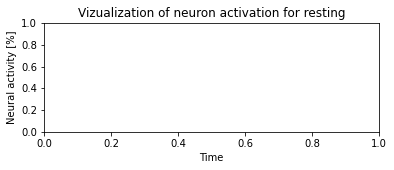

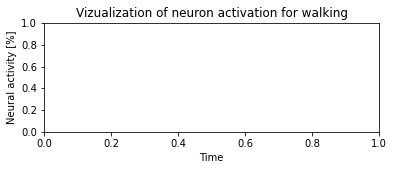

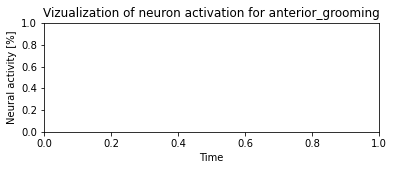

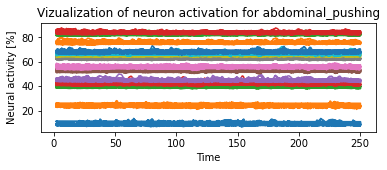

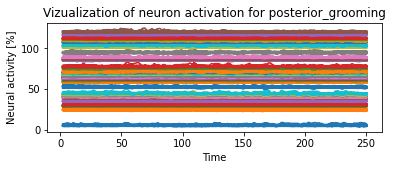

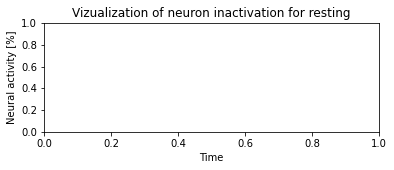

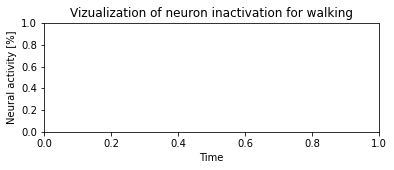

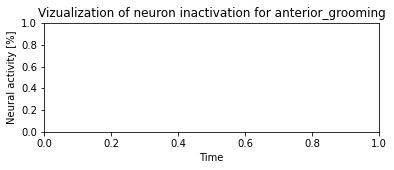

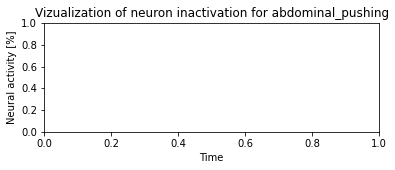

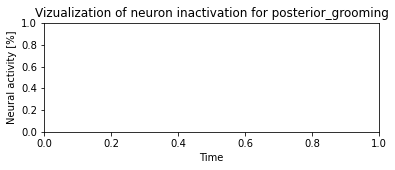

In [21]:
#plots activation for each behaviors
treshold=0.9
#get neurons with anormal activation/unactivation in behaviors
plots_act= val.copy()
plots_inact= val.copy()
for i in range (len(behaviors)):
    for j in range (122):
        if (plots_act[i,j] < treshold):
            plots_act[i,j] = 0
        if (plots_inact[i,j] > -treshold):
            plots_inact[i,j] = 0
            
for i in range (len(behaviors)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,2))

    for j in range (122):
        if plots_act[i,j]>0.0 :
            plt.plot(std_Df_f['t'], std_Df_f['neuron_'+ str(j)]+j)
    name_ax.set_title('Vizualization of neuron activation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    plt.show()

for i in range (len(behaviors)):  
    #try to isolate one behavior for each neuron
    name_fig='fig_beh_'+str(i)
    name_ax='ax_'+str(i)
    name_fig, name_ax = plt.subplots(figsize = (6,2))    
    for j in range (122):
        if plots_inact[i,j]<0.0 :
            plt.plot(std_Df_f['t'], std_Df_f['neuron_'+ str(j)]+j)
    name_ax.set_title('Vizualization of neuron inactivation for ' + behaviors[i])
    name_ax.set_ylabel('Neural activity [%]')
    name_ax.set_xlabel('Time')
    plt.show()

### B. correlation between neural data and behavioral data

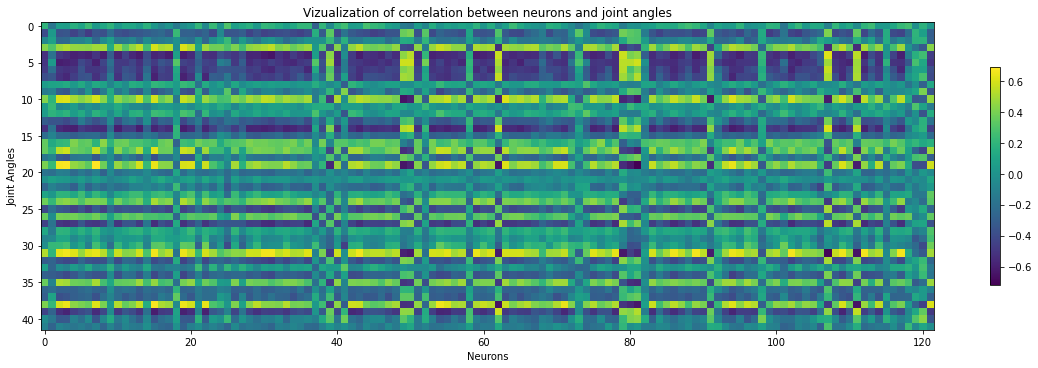

In [22]:
from scipy import stats
nbr_neurons = 122
nbr_beh_param = filtered_beh_df.filter(regex='angle').columns
correlation = np.zeros((len(nbr_beh_param),nbr_neurons))

for j in range (len(nbr_beh_param)): 
    twop_index = filtered_beh_df[filtered_beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
    values = filtered_beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[j]].to_numpy()
    angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)  
    for i in range (nbr_neurons) : 
        a=stats.spearmanr(std_Df_f['neuron_'+str(i)][std_Df_f.index.get_level_values('Trial')==0], angl_DS) 
        correlation[j,i]=a[0]
#plot
fig, ax2 = plt.subplots(figsize = (20,40))
ax2.set_title('Vizualization of correlation between neurons and joint angles')
ax2.set_ylabel('Joint Angles')
ax2.set_xlabel('Neurons')
plt.imshow(correlation)
plt.colorbar(shrink=0.1)
plt.show()
fig.savefig('report_images/correlation_btw_joint_angles_&_neuron.png')

### C. Compare clustered neurons from Clustering part (3.B)

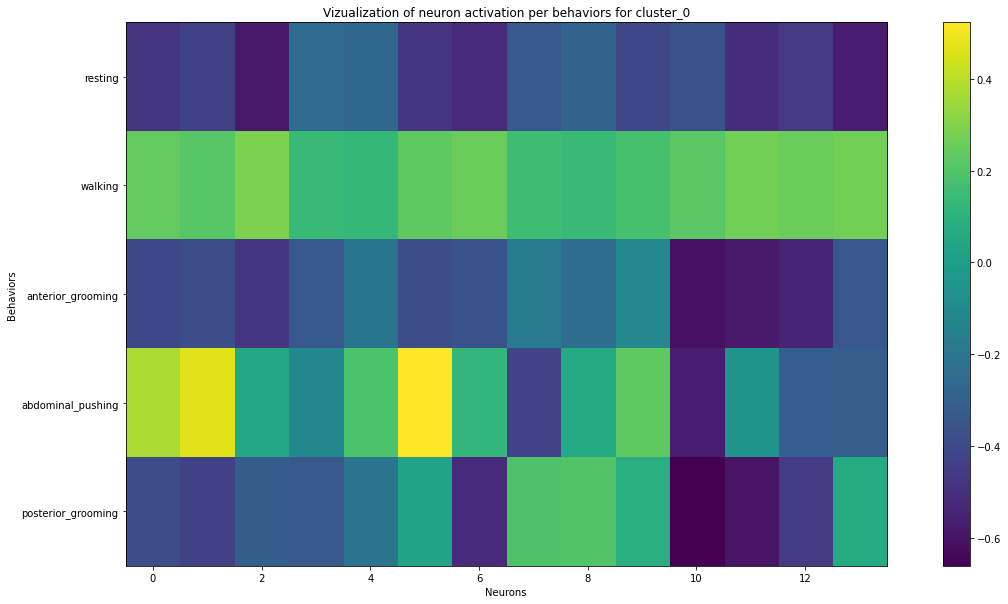

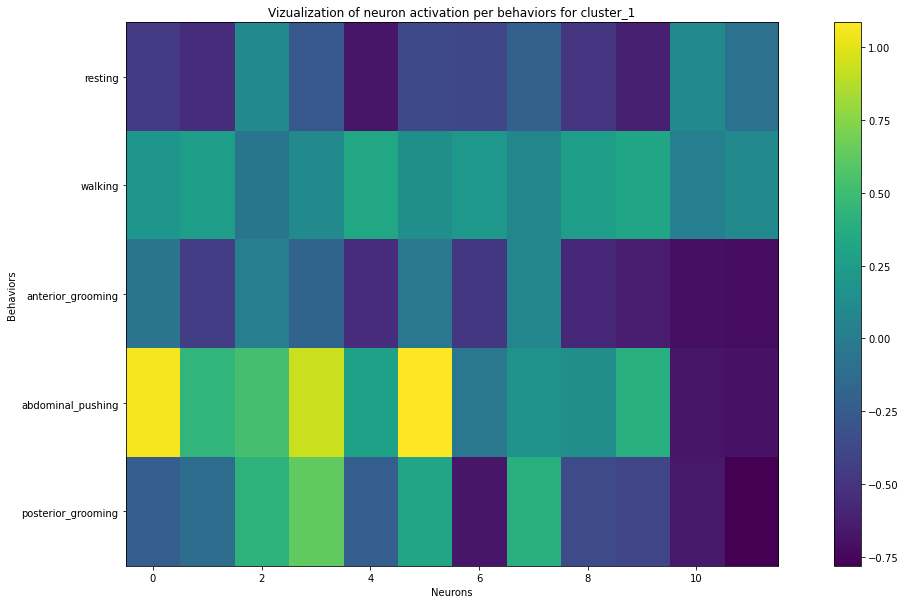

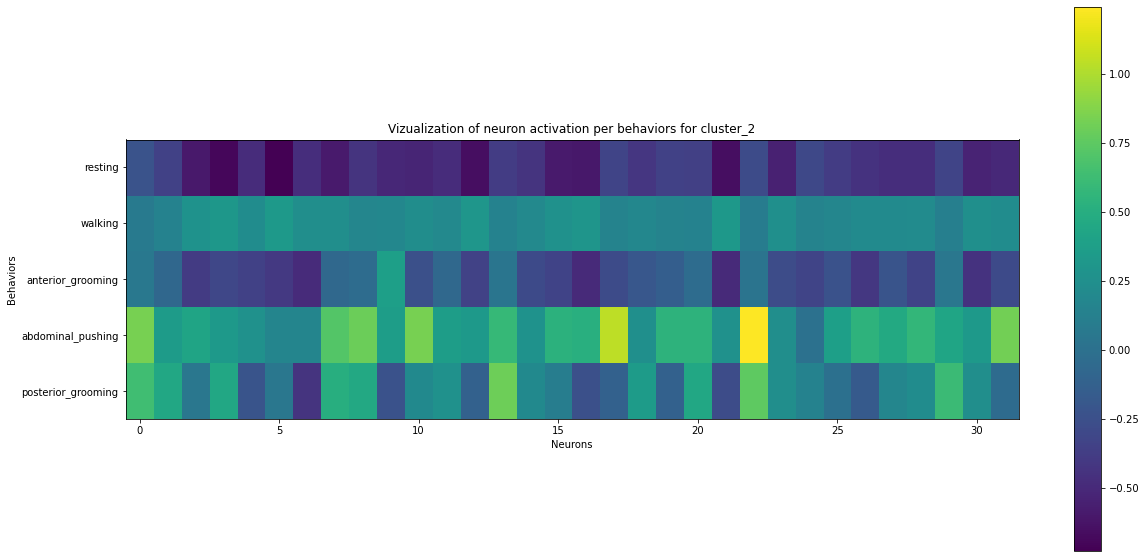

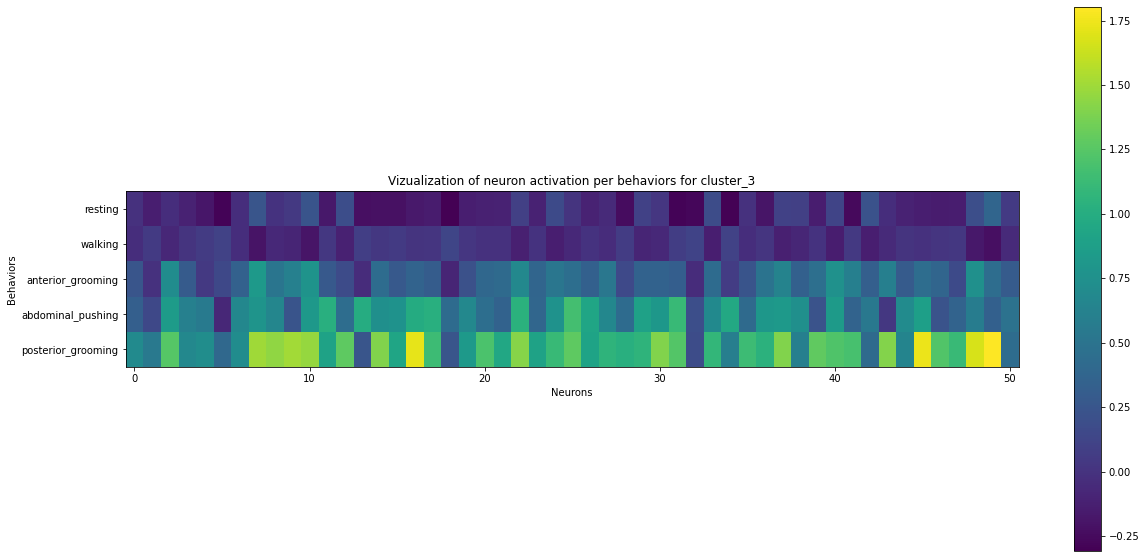

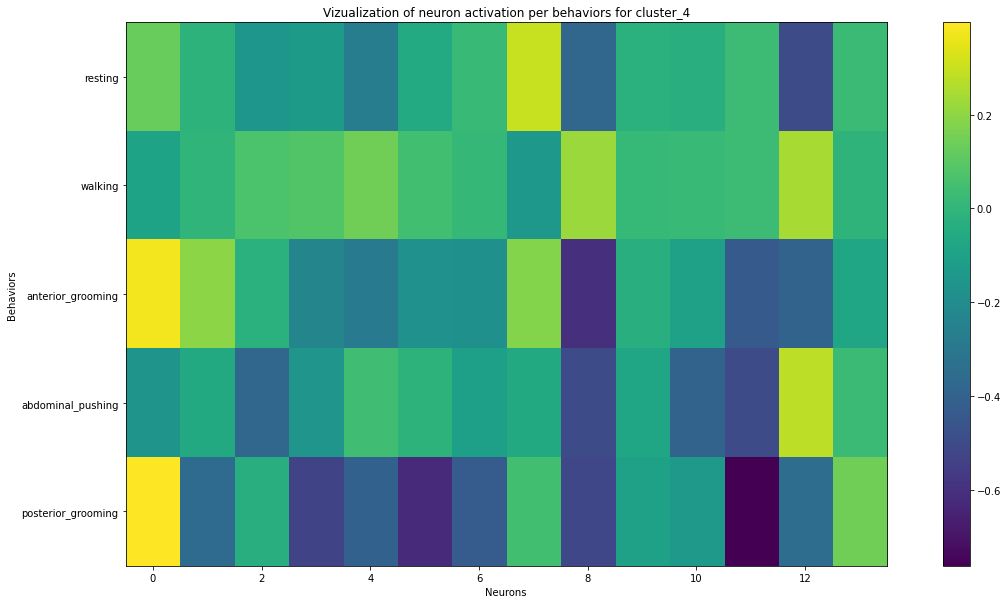

In [23]:
from numpy.linalg import norm
import random
w_norm= kmeans_labels
compare=[]
compare.append([i for i, n in enumerate(w_norm) if n == 0])
compare.append([i for i, n in enumerate(w_norm) if n == 1])
compare.append([i for i, n in enumerate(w_norm) if n == 2])
compare.append([i for i, n in enumerate(w_norm) if n == 3])
compare.append([i for i, n in enumerate(w_norm) if n == 4])

#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
behaviors = ['resting', 'walking', 'anterior_grooming', 'abdominal_pushing', 'posterior_grooming']
ytick=[0,1,2,3,4]

for k in range (5):
    val = np.zeros((5,len(compare[k])))
    i=0
    j=0
    #get corresponding neurons
    for i in range (len(behaviors)):
        behavior_data = std_Df_f[std_Df_f['Manual']==behaviors[i]]
        for j in range (len(val[i])):
            val[i,j] = behavior_data['neuron_' + str(compare[k][j])].mean()
    
    name='fig_cluster_'+str(k)
    name_ax='fig_ax_'+str(k)
    name, name_ax = plt.subplots(figsize = (20,10))
    name_ax.set_yticks(ytick)
    name_ax.set_yticklabels(behaviors)
    name_ax.set_title('Vizualization of neuron activation per behaviors for cluster_'+str(k))
    name_ax.set_ylabel('Behaviors')
    name_ax.set_xlabel('Neurons')
    plt.imshow(val, aspect=2)
    plt.colorbar()
    plt.show()
    name.savefig('report_images/neuron_act_for_cluster_'+str(k)+'.png')

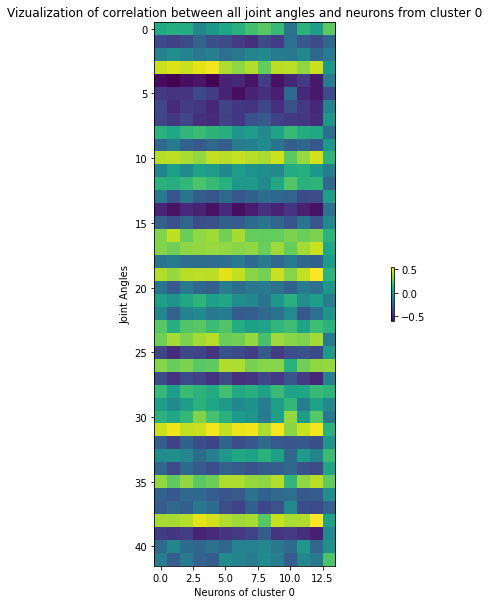

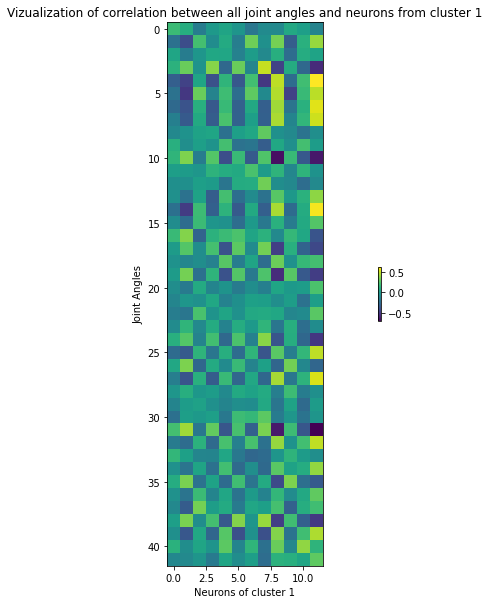

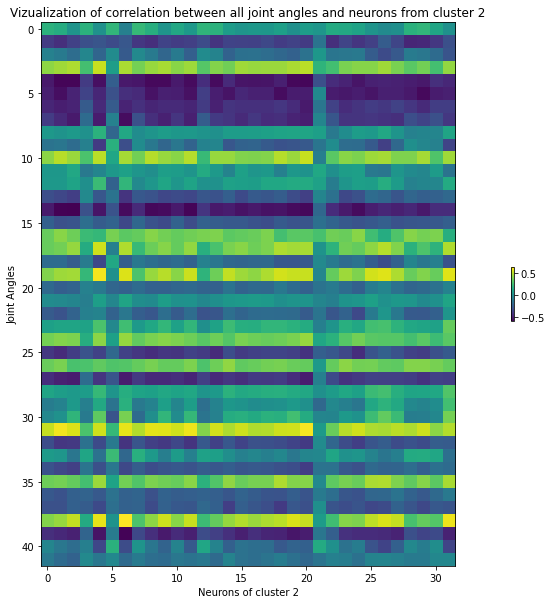

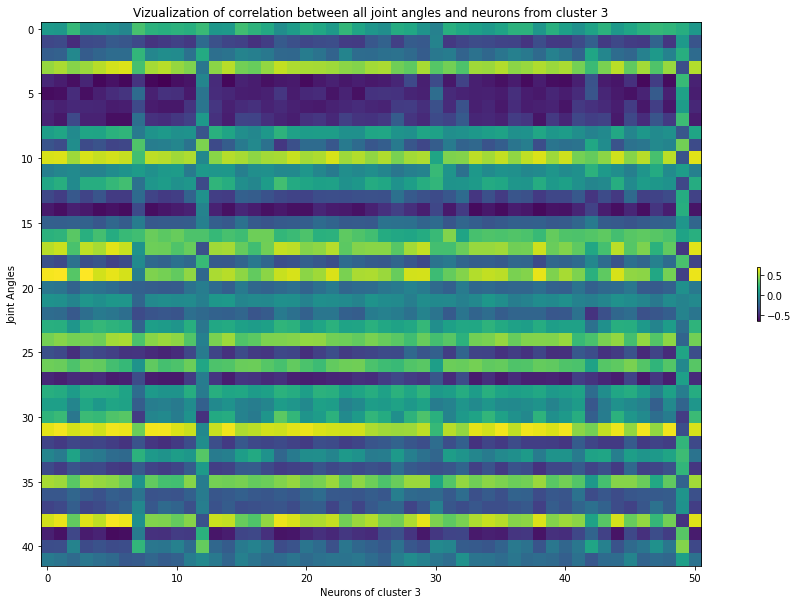

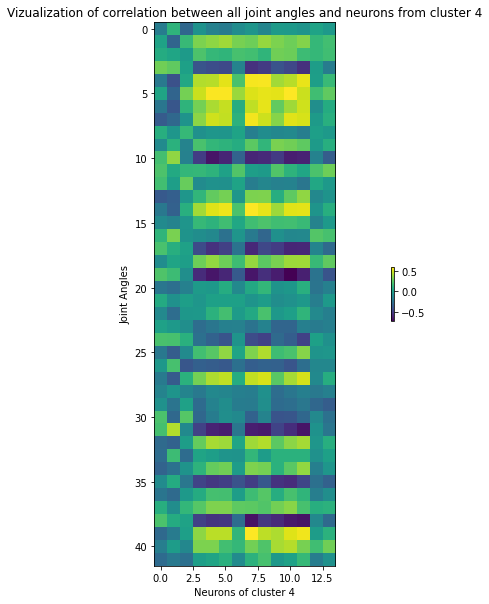

In [24]:
#step2 : vizualization of neuron activation PER BEHAVIOR
#get manual labelling of behaviors
from scipy import stats

for k in range (5):
    val = np.zeros((5,len(compare[k])))
    
    ### correlation between neural data and behavioral data
    nbr_beh_param = filtered_beh_df.filter(regex='angle').columns
    correlation = np.zeros((len(nbr_beh_param),len(compare[k])))

    #DONE ONLY FOR TRIAL 0
    for i in range (len(nbr_beh_param)): 
        twop_index = filtered_beh_df[filtered_beh_df.index.get_level_values('Trial')==0]['twop_index'].to_numpy()
        values = filtered_beh_df.loc[(210301, 'J1xCI9', 1, 0), nbr_beh_param[i]].to_numpy()
        angl_DS = reduce_during_2p_frame(twop_index, values, function=reduce_mean)  
        for j in range (len(compare[k])) : 
            a=stats.spearmanr(std_Df_f['neuron_'+str(compare[k][j])][std_Df_f.index.get_level_values('Trial')==0], angl_DS) 
            correlation[i,j]=a[0]
    #plot
    name='fig_cluster_'+str(k)
    name_ax='fig_ax_'+str(k)
    name, name_ax = plt.subplots(figsize = (20,10))
    name_ax.set_title('Vizualization of correlation between all joint angles and neurons from cluster '+str(k))
    name_ax.set_ylabel('Joint Angles')
    name_ax.set_xlabel('Neurons of cluster '+str(k))
    plt.imshow(correlation)
    plt.colorbar(shrink=0.1)
    plt.show()
    name.savefig('report_images/corr_btw_joint_angles_neuron_cluster'+str(k)+'.png')